In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

tfd = tfp.distributions
tfb = tfp.bijectors


In [2]:
#@title Utils { display-mode: "form" }
def print_subclasses_from_module(module, base_class, maxwidth=80):
  import functools, inspect, sys
  subclasses = [name for name, obj in inspect.getmembers(module)
                if inspect.isclass(obj) and issubclass(obj, base_class)]
  def red(acc, x):
    if not acc or len(acc[-1]) + len(x) + 2 > maxwidth:
      acc.append(x)
    else:
      acc[-1] += ", " + x
    return acc
  print('\n'.join(functools.reduce(red, subclasses, [])))


In [3]:
# Tensorflow

mats = tf.random.uniform(shape=[1000, 10, 10])
vecs = tf.random.uniform(shape=[1000, 10, 1])

def for_loop_solve():
  return np.array(
    [tf.linalg.solve(mats[i, ...], vecs[i, ...]) for i in range(1000)])

def vectorized_solve():
  return tf.linalg.solve(mats, vecs)

# Vectorization for the win!
%timeit for_loop_solve()
%timeit vectorized_solve()


321 ms ± 6.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
397 µs ± 52.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
# Code can run seamlessly on a GPU, just change Colab runtime type
# in the 'Runtime' menu.
if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")


Using a CPU


In [5]:
# Differentiation
a = tf.constant(np.pi)
b = tf.constant(np.e)
with tf.GradientTape() as tape:
  tape.watch([a, b])
  c = .5 * (a**2 + b**2)
grads = tape.gradient(c, [a, b])
print(grads[0])
print(grads[1])


tf.Tensor(3.1415927, shape=(), dtype=float32)
tf.Tensor(2.7182817, shape=(), dtype=float32)


In [6]:
# Probability

In [7]:
# A standard normal
normal = tfd.Normal(loc=0., scale=1.)
print(normal)


tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


In [8]:
# A standard normal
normal = tfd.Normal(loc=0., scale=1.)
print(normal)


tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


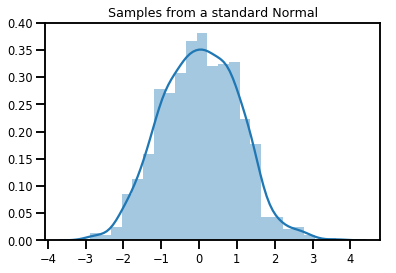

In [9]:
# Plot 1000 samples from a standard normal
samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Samples from a standard Normal")
plt.show()


In [10]:
# Compute the log_prob of a point in the event space of `normal`
print(normal.log_prob(0.).numpy(), normal.prob(0.).numpy())

-0.9189385 0.3989423


In [11]:
# Compute the log_prob of a few points
normal.log_prob([-1., 0., 1.])


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4189385, -0.9189385, -1.4189385], dtype=float32)>

# Distributions and Shapes
Numpy ndarrays and TensorFlow Tensors have shapes.

TensorFlow Probability Distributions have shape semantics -- we partition shapes into semantically distinct pieces, even though the same chunk of memory (Tensor/ndarray) is used for the whole everything.

- Batch shape denotes a collection of Distributions with distinct parameters
- Event shape denotes the shape of samples from the Distribution.
We always put batch shapes on the "left" and event shapes on the "right".


In [12]:
# Create a batch of 3 normals, and plot 1000 samples from each
normals = tfd.Normal([-2.5, 0., 2.5], 1.)  # The scale parameter broadacasts!
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [13]:
samples = normals.sample(1000)
print("Shape of samples:", samples.shape)
samples

Shape of samples: (1000, 3)


<tf.Tensor: shape=(1000, 3), dtype=float32, numpy=
array([[-3.426008  , -0.8123231 ,  2.4462335 ],
       [-3.6163125 , -1.3352301 ,  2.890461  ],
       [-1.3838477 , -0.50515014,  2.442475  ],
       ...,
       [-2.1696784 , -1.4840844 ,  4.0386286 ],
       [-2.6442587 ,  0.6804036 ,  1.6338289 ],
       [-3.8941069 ,  0.5379578 ,  2.5307958 ]], dtype=float32)>

In [14]:
# Sample shapes can themselves be more complicated
print("Shape of samples:", normals.sample([10, 10, 10]).shape)
normals.sample([2, 4])

Shape of samples: (10, 10, 10, 3)


<tf.Tensor: shape=(2, 4, 3), dtype=float32, numpy=
array([[[-2.8913467 ,  0.6501003 ,  5.146003  ],
        [-2.540428  ,  0.63941985,  2.6202364 ],
        [-2.1708035 , -1.7784587 ,  1.9817356 ],
        [-2.538059  ,  2.1544576 ,  1.6725786 ]],

       [[-1.9581262 , -0.8733158 ,  2.2070296 ],
        [-0.7289617 , -0.50565714,  1.403519  ],
        [-1.5610825 ,  0.29507607,  1.2030314 ],
        [-3.0512621 , -0.27599227,  3.368585  ]]], dtype=float32)>

In [15]:
# A batch of normals gives a batch of log_probs.
print(normals.log_prob([-2.5, 0.0, 2.5]))


tf.Tensor([-0.9189385 -0.9189385 -0.9189385], shape=(3,), dtype=float32)


In [16]:
# But this would work:
a = np.zeros([200, 1]) + np.zeros(3)
print("Broadcast shape:", a.shape)


Broadcast shape: (200, 3)


In [17]:
# And so will this!
xs = np.linspace(-6, 6, 200)[..., np.newaxis]
# => shape = [200, 1]

lps = normals.log_prob(xs)
print("Broadcast log_prob shape:", lps.shape)


Broadcast log_prob shape: (200, 3)


In [18]:
# And so will this!
xs = np.linspace(-6, 6, 200)[..., np.newaxis]
# => shape = [200, 1]
print(np.tile(xs, 3).shape)
lps = normals.log_prob(xs)
print("Broadcast log_prob shape:", lps.shape)


(200, 3)
Broadcast log_prob shape: (200, 3)


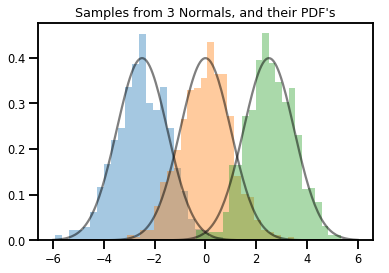

In [19]:
# Summarizing visually
for i in range(3):
  sns.distplot(samples[:, i], kde=False, norm_hist=True)
plt.plot(np.tile(xs, 3), normals.prob(xs), c='k', alpha=.5)
plt.title("Samples from 3 Normals, and their PDF's")
plt.show()


In [62]:
# Simple Inference
theta_true = 0.7
true_p = np.array([1-theta_true, theta_true])
num_examples = 128
xs = np.random.choice(2, p=true_p, size=num_examples).astype(np.float32)

In [63]:
def joint_log_prob_Beta_Bernoulli(p, x):
    # w ~ Beta(1,1)
    # x_i ~ Bernoulli(w)
    
    rv_p = tfd.Beta(concentration0=1, concentration1=1)
    rv_x = tfd.Bernoulli(probs=p)
    return (rv_p.log_prob(p) + tf.reduce_sum(rv_x.log_prob(x)))

X = tfd.Bernoulli(probs=0.7)
P = tfd.Beta(concentration0=1, concentration1=1)
print(P.log_prob(0.7))
print(tf.reduce_sum(X.log_prob(xs)))
print(P.log_prob(0.7) +tf.reduce_sum(X.log_prob(xs)))


tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(-82.9355, shape=(), dtype=float32)
tf.Tensor(-82.9355, shape=(), dtype=float32)


In [64]:
# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior_Beta_Bernoulli(p):
  return joint_log_prob_Beta_Bernoulli(p, xs)

In [65]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior_Beta_Bernoulli,
  step_size=np.float64(.1),
  num_leapfrog_steps=2)

In [66]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=hmc_kernel,
    trace_fn=lambda current_state, kernel_results: kernel_results)

In [67]:
initial_state = [0.5]

Acceptance rate: 0.0941


/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


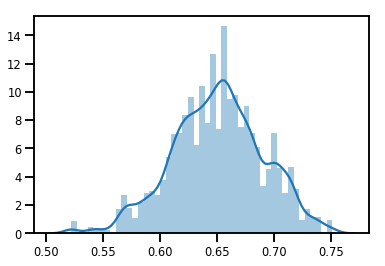

In [68]:
samples, kernel_results = run_chain(initial_state, num_results=10000,num_burnin_steps=1000)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())
# Trace plots
# Histogram of samples
sns.distplot(samples)
plt.show()


In [69]:
np.mean(xs)

0.65625

In [70]:
jds = tfd.JointDistributionSequential([
    tfd.Beta(concentration0=1, concentration1=1), # p
    lambda p: tfd.Bernoulli(probs=p) # x
])

In [71]:
dists, sample = jds.sample_distributions()
sample


[<tf.Tensor: shape=(), dtype=float32, numpy=0.030264765>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>]

In [88]:
jdn = tfd.JointDistributionNamed({
    'theta': tfd.Beta(concentration0=1, concentration1=1),
    'x_t': lambda theta:tfd.Independent(tfd.Bernoulli(probs=theta), reinterpreted_batch_ndims=1)})
?tfd.Independent

Init signature:
tfd.Independent(
    distribution,
    reinterpreted_batch_ndims=None,
    validate_args=False,
    experimental_use_kahan_sum=False,
    name=None,
)
Docstring:     
Independent distribution from batch of distributions.

This distribution is useful for regarding a collection of independent,
non-identical distributions as a single random variable. For example, the
`Independent` distribution composed of a collection of `Bernoulli`
distributions might define a distribution over an image (where each
`Bernoulli` is a distribution over each pixel).

More precisely, a collection of `B` (independent) `E`-variate random variables
(rv) `{X_1, ..., X_B}`, can be regarded as a `[B, E]`-variate random variable
`(X_1, ..., X_B)` with probability
`p(x_1, ..., x_B) = p_1(x_1) * ... * p_B(x_B)` where `p_b(X_b)` is the
probability of the `b`-th rv. More generally `B, E` can be arbitrary shapes.

Similarly, the `Independent` distribution specifies a distribution over `[B,
E]`-shaped even

In [86]:
dists, sample = jdn.sample_distributions()
dists, sample


ValueError: reinterpreted_batch_ndims(1) cannot exceed distribution.batch_ndims(0)

In [74]:
jdn.resolve_graph()

(('theta', ()), ('x_t', ('theta',)))

In [75]:
def target_log_prob(theta):
    return jdn.log_prob(theta = theta, x_t = xs)

In [76]:
# Get some samples
print(jdn.sample(10, seed=1234))


{'theta': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.89278746, 0.3089692 , 0.1726906 , 0.641515  , 0.6830413 ,
       0.8998901 , 0.06377372, 0.97722626, 0.26664722, 0.24276856],
      dtype=float32)>, 'x_t': <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1], dtype=int32)>}


In [84]:
# Do a simple grid approximation
thetas = np.linspace(start=0.0, stop=1.0, num=1000)
# Compute joint-log-probability.
for theta in thetas:
    print(theta, target_log_prob(theta))


0.0 tf.Tensor(
[-inf   0.   0.   0. -inf -inf -inf -inf -inf   0.   0. -inf   0. -inf
   0. -inf -inf -inf   0. -inf -inf -inf -inf -inf -inf   0. -inf -inf
   0. -inf -inf -inf -inf -inf -inf -inf -inf   0. -inf   0. -inf   0.
   0.   0.   0. -inf -inf -inf -inf   0. -inf   0. -inf -inf -inf -inf
   0.   0.   0.   0.   0. -inf -inf -inf   0. -inf -inf   0. -inf -inf
 -inf   0. -inf -inf   0.   0.   0. -inf -inf -inf -inf -inf   0.   0.
 -inf   0.   0. -inf -inf -inf -inf -inf   0.   0. -inf -inf -inf -inf
   0. -inf -inf -inf -inf -inf -inf -inf   0. -inf -inf -inf -inf   0.
 -inf   0. -inf   0. -inf -inf -inf -inf -inf   0. -inf   0. -inf   0.
   0. -inf], shape=(128,), dtype=float32)
0.001001001001001001 tf.Tensor(
[-6.9067550e+00 -1.0015023e-03 -1.0015023e-03 -1.0015023e-03
 -6.9067550e+00 -6.9067550e+00 -6.9067550e+00 -6.9067550e+00
 -6.9067550e+00 -1.0015023e-03 -1.0015023e-03 -6.9067550e+00
 -1.0015023e-03 -6.9067550e+00 -1.0015023e-03 -6.9067550e+00
 -6.9067550e+00 -6.9067550e+

In [83]:
print(model_log_probs)
# Plot the results. 
sns.lineplot(x=thetas, y=model_log_probs)

[[          -inf  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00           -inf]
 [-6.9067550e+00 -1.0015023e-03 -1.0015023e-03 ... -1.0015023e-03
  -1.0015023e-03 -6.9067550e+00]
 [-6.2136078e+00 -2.0040087e-03 -2.0040087e-03 ... -2.0040087e-03
  -2.0040087e-03 -6.2136078e+00]
 ...
 [-2.0040076e-03 -6.2136083e+00 -6.2136083e+00 ... -6.2136083e+00
  -6.2136083e+00 -2.0040076e-03]
 [-1.0015017e-03 -6.9067554e+00 -6.9067554e+00 ... -6.9067554e+00
  -6.9067554e+00 -1.0015017e-03]
 [ 0.0000000e+00           -inf           -inf ...           -inf
            -inf  0.0000000e+00]]


Exception: Data must be 1-dimensional

In [43]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob,
  step_size=np.float64(.1),
  num_leapfrog_steps=2)

# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=hmc_kernel,
    trace_fn=lambda current_state, kernel_results: kernel_results)

In [44]:
samples = run_chain(initial_state)

ValueError: in user code:

    <ipython-input-34-77ab10a6f03a>:11 run_chain  *
        return tfp.mcmc.sample_chain(
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:375 sample_chain  **
        parallel_iterations=parallel_iterations)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:457 trace_scan
        parallel_iterations=parallel_iterations)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:602 new_func
        return func(*args, **kwargs)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:2541 while_loop_v2
        return_same_structure=True)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:2738 while_loop
        back_prop=back_prop)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/while_v2.py:202 while_loop
        add_control_dependencies=add_control_dependencies)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:999 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/while_v2.py:180 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:438 _body
        state = loop_fn(state, elem)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:359 _trace_scan_fn
        parallel_iterations=parallel_iterations)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:328 smart_for_loop
        parallel_iterations=parallel_iterations
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:602 new_func
        return func(*args, **kwargs)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:2541 while_loop_v2
        return_same_structure=True)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:2738 while_loop
        back_prop=back_prop)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/while_v2.py:202 while_loop
        add_control_dependencies=add_control_dependencies)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:999 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/while_v2.py:180 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:326 <lambda>
        body=lambda i, *args: [i + 1] + list(body_fn(*args)),
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:352 _seeded_one_step
        kernel.one_step(*state_and_results, **one_step_kwargs))
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/hmc.py:554 one_step
        current_state, previous_kernel_results, seed=seed)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:219 one_step
        to_sum, name='compute_log_accept_ratio')
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:199 safe_sum
        x = tf.add_n(x)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3754 add_n
        return gen_math_ops.add_n(inputs, name=name)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:470 add_n
        "AddN", inputs=inputs, name=name)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:601 _create_op_internal
        compute_device)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3565 _create_op_internal
        op_def=op_def)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2042 __init__
        control_input_ops, op_def)
    /home/olethros/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Shapes must be equal rank, but are 1 and 0
    	From merging shape 1 with other shapes. for '{{node mcmc_sample_chain/trace_scan/while/smart_for_loop/while/mh_one_step/compute_log_accept_ratio/AddN}} = AddN[N=3, T=DT_FLOAT](mcmc_sample_chain/trace_scan/while/smart_for_loop/while/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while:5, mcmc_sample_chain/trace_scan/while/smart_for_loop/while/mh_one_step/Neg, mcmc_sample_chain/trace_scan/while/smart_for_loop/while/mh_one_step/hmc_kernel_one_step/compute_log_acceptance_correction/mul)' with input shapes: [128], [128], [].
